In [21]:
!pip install scikit-fuzzy

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import jaccard_score
from scipy import ndimage
from scipy.ndimage import binary_erosion, binary_dilation
from scipy.spatial.distance import directed_hausdorff
import skfuzzy as fuzz

In [23]:
# Load image
image = cv2.imread("/kaggle/input/datasets/inhvnnhn/krd-wbc-dataset/KRD WBC Dataset/train/images/image1.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Resize for faster processing
image = cv2.resize(image, (256, 256))

# Blur to remove noise
blur = cv2.GaussianBlur(image, (5, 5), 0)

# Reshape for clustering
pixel_values = blur.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

In [24]:
k = 3  # nucleus, cytoplasm, background

kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = kmeans.fit_predict(pixel_values)

# Convert labels back to image
segmented_kmeans = labels.reshape((256, 256))

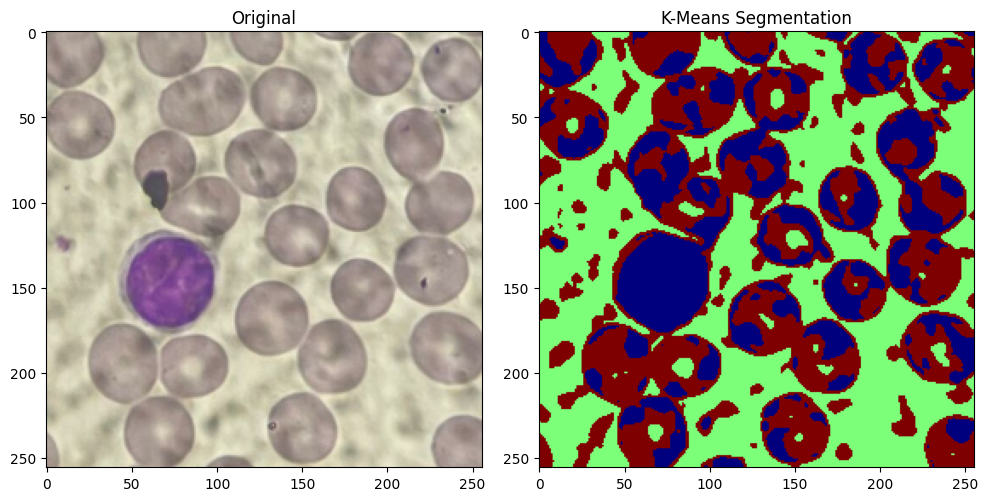

In [25]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(segmented_kmeans, cmap='jet')
plt.title("K-Means Segmentation")
plt.tight_layout()
plt.show()

In [26]:
# Transpose data for FCM (skfuzzy expects features x samples)
pixel_values_T = pixel_values.T

cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    pixel_values_T,
    c=3,
    m=2,
    error=0.005,
    maxiter=1000
)

# Assign each pixel to the cluster with highest membership
fcm_labels = np.argmax(u, axis=0)
segmented_fcm = fcm_labels.reshape((256, 256))

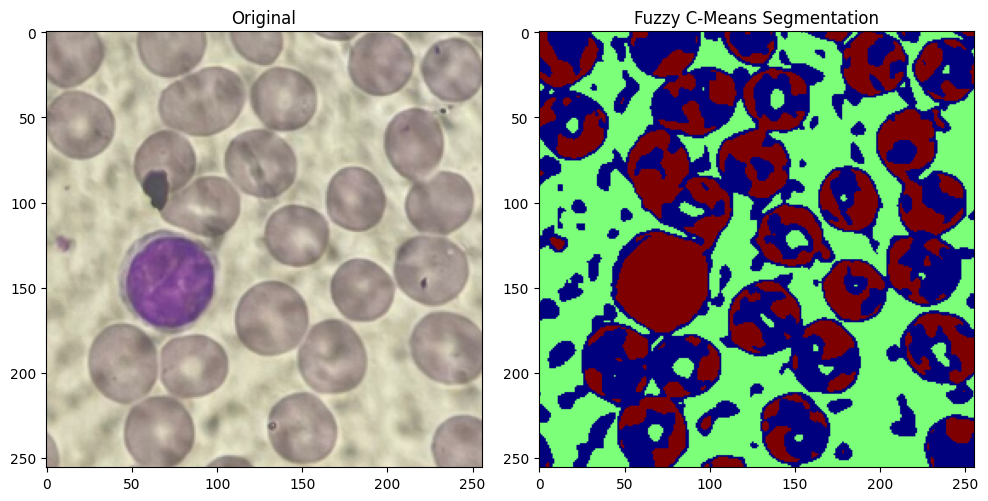

In [27]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(segmented_fcm, cmap='jet')
plt.title("Fuzzy C-Means Segmentation")
plt.tight_layout()
plt.show()

In [28]:
def extract_nucleus_mask(segmented, cluster_idx):
   
    raw_mask = (segmented == cluster_idx).astype(np.uint8)

    # Remove small isolated noise with morphological opening
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    cleaned = cv2.morphologyEx(raw_mask, cv2.MORPH_OPEN, kernel)

    # Label connected components
    labeled, num_features = ndimage.label(cleaned)
    if num_features == 0:
        return raw_mask  # fallback: nothing found after opening

    # Keep only the largest connected component (= true nucleus)
    component_sizes = ndimage.sum(cleaned, labeled, range(1, num_features + 1))
    largest_label = np.argmax(component_sizes) + 1  # labels start at 1

    nucleus_mask = (labeled == largest_label).astype(np.uint8)

    # Fill any interior holes
    nucleus_mask = ndimage.binary_fill_holes(nucleus_mask).astype(np.uint8)
    return nucleus_mask


#  K-Means 
km_centers = kmeans.cluster_centers_
nucleus_cluster_km = np.argmin(np.sum(km_centers, axis=1))

nucleus_mask_kmeans = extract_nucleus_mask(segmented_kmeans, nucleus_cluster_km)



# FCM 
fcm_centers = cntr
nucleus_cluster_fcm = np.argmin(np.sum(fcm_centers, axis=1))

nucleus_mask_fcm = extract_nucleus_mask(segmented_fcm, nucleus_cluster_fcm)



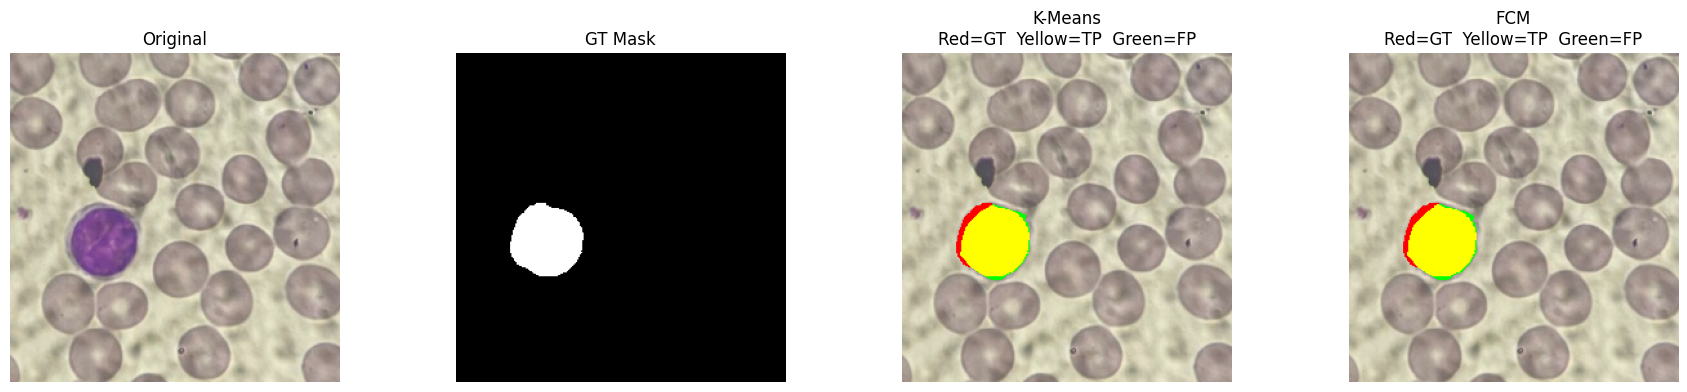


K-Means IoU : 0.8554
FCM     IoU : 0.8548


In [29]:
# Load ground truth mask
gt_mask = cv2.imread("/kaggle/input/datasets/inhvnnhn/krd-wbc-dataset/KRD WBC Dataset/train/mask/image1.jpg", 0)
gt_mask = cv2.resize(gt_mask, (256, 256))
gt_mask = (gt_mask > 127).astype(np.uint8)


# Colour overlay: Red=GT only, Yellow=TP, Green=FP 
def make_overlay(image, pred_mask, gt_mask):
    overlay = image.copy().astype(np.uint8)
    overlay[gt_mask == 1] = [255, 0, 0]                                 # Red   = GT only
    overlay[(pred_mask == 1) & (gt_mask == 1)] = [255, 255, 0]          # Yellow = TP
    overlay[(pred_mask == 1) & (gt_mask == 0)] = [0,   255, 0]          # Green  = FP
    return overlay

overlay_km  = make_overlay(image, nucleus_mask_kmeans, gt_mask)
overlay_fcm = make_overlay(image, nucleus_mask_fcm,    gt_mask)

fig, axes = plt.subplots(1, 4, figsize=(18, 4))
axes[0].imshow(image);                    axes[0].set_title("Original");           axes[0].axis('off')
axes[1].imshow(gt_mask, cmap='gray');     axes[1].set_title("GT Mask");            axes[1].axis('off')
axes[2].imshow(overlay_km);              axes[2].set_title("K-Means\nRed=GT  Yellow=TP  Green=FP"); axes[2].axis('off')
axes[3].imshow(overlay_fcm);             axes[3].set_title("FCM\nRed=GT  Yellow=TP  Green=FP");     axes[3].axis('off')
plt.tight_layout()
plt.show()

# IoU 
gt  = gt_mask.flatten()
km  = nucleus_mask_kmeans.flatten()
fcm_flat = nucleus_mask_fcm.flatten()

iou_kmeans = jaccard_score(gt, km)
iou_fcm    = jaccard_score(gt, fcm_flat)

print(f"\nK-Means IoU : {iou_kmeans:.4f}")
print(f"FCM     IoU : {iou_fcm:.4f}")

Metric                              K-Means          FCM
------------------------------------------------------
IoU Score                            0.8554       0.8548
Hausdorff Distance (px)              5.6569       5.6569
Boundary Precision                   0.6987       0.6899
Boundary Recall                      0.6810       0.6933
Boundary F1-Score                    0.6897       0.6916


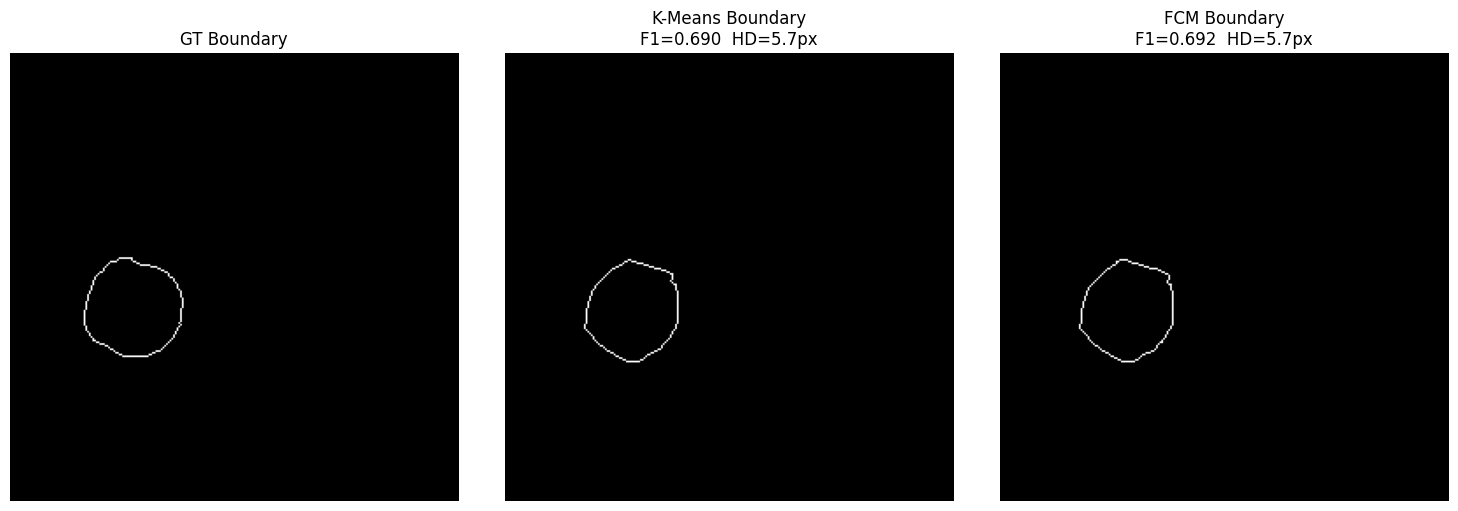

In [30]:
def extract_boundary(mask):
    """Extract boundary pixels by subtracting eroded mask from original."""
    eroded = binary_erosion(mask)
    boundary = mask.astype(bool) & ~eroded
    return boundary.astype(np.uint8)


def hausdorff_distance(mask1, mask2):
    """Compute symmetric Hausdorff distance between two binary masks."""
    pts1 = np.argwhere(mask1)
    pts2 = np.argwhere(mask2)
    if len(pts1) == 0 or len(pts2) == 0:
        return float('inf')
    d1 = directed_hausdorff(pts1, pts2)[0]
    d2 = directed_hausdorff(pts2, pts1)[0]
    return max(d1, d2)


def boundary_f1_score(pred_boundary, gt_boundary, tolerance=2):
    """
    Boundary F1-Score with pixel tolerance.
    A predicted boundary pixel counts as TP if it lies within
    'tolerance' pixels of any GT boundary pixel (and vice versa).
    """
    struct = np.ones((2 * tolerance + 1, 2 * tolerance + 1))

    gt_dilated   = binary_dilation(gt_boundary.astype(bool),   structure=struct)
    pred_dilated = binary_dilation(pred_boundary.astype(bool), structure=struct)

    tp_pred = np.sum(pred_boundary.astype(bool) & gt_dilated)
    tp_gt   = np.sum(gt_boundary.astype(bool)   & pred_dilated)

    precision = tp_pred / (np.sum(pred_boundary) + 1e-8)
    recall    = tp_gt   / (np.sum(gt_boundary)   + 1e-8)
    f1        = 2 * precision * recall / (precision + recall + 1e-8)
    return precision, recall, f1


# Extract boundaries
gt_boundary  = extract_boundary(gt_mask)
km_boundary  = extract_boundary(nucleus_mask_kmeans)
fcm_boundary = extract_boundary(nucleus_mask_fcm)

# Hausdorff Distance 
hd_kmeans = hausdorff_distance(km_boundary,  gt_boundary)
hd_fcm    = hausdorff_distance(fcm_boundary, gt_boundary)

# ── Boundary F1-Score 
prec_km,  rec_km,  f1_km  = boundary_f1_score(km_boundary,  gt_boundary)
prec_fcm, rec_fcm, f1_fcm = boundary_f1_score(fcm_boundary, gt_boundary)

# Summary table 
print(f"{'Metric':<30} {'K-Means':>12} {'FCM':>12}")
print("-" * 54)
print(f"{'IoU Score':<30} {iou_kmeans:>12.4f} {iou_fcm:>12.4f}")
print(f"{'Hausdorff Distance (px)':<30} {hd_kmeans:>12.4f} {hd_fcm:>12.4f}")
print(f"{'Boundary Precision':<30} {prec_km:>12.4f} {prec_fcm:>12.4f}")
print(f"{'Boundary Recall':<30} {rec_km:>12.4f} {rec_fcm:>12.4f}")
print(f"{'Boundary F1-Score':<30} {f1_km:>12.4f} {f1_fcm:>12.4f}")

#  Boundary visualisation 
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(gt_boundary,  cmap='gray'); axes[0].set_title("GT Boundary")
axes[1].imshow(km_boundary,  cmap='gray'); axes[1].set_title(f"K-Means Boundary\nF1={f1_km:.3f}  HD={hd_kmeans:.1f}px")
axes[2].imshow(fcm_boundary, cmap='gray'); axes[2].set_title(f"FCM Boundary\nF1={f1_fcm:.3f}  HD={hd_fcm:.1f}px")
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()